# References
- https://www.tensorflow.org/recommenders/examples/basic_retrieval
- https://www.tensorflow.org/recommenders/examples/basic_ranking

# Initial Imports

In [1]:
# Run if using Google Colab
%pip install -q tensorflow-recommenders


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

import tensorflow_recommenders as tfrs

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data

In [3]:
events_csv_path = '../events.csv'
ratings_csv_path = '../ratings.csv'
key='9aadb790'
user_count=1000
generate_count=1000
event_count=400

ratings_df = pd.read_csv(f"https://my.api.mockaroo.com/rating.json?key={key}&count={generate_count}&user_id={user_count}&event_id={event_count}")

# drop duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        ratings_df.drop(index=row, inplace=True)

ratings_df.reset_index(drop=True, inplace=True)

# check for duplicated
duplicated_series = ratings_df.duplicated(subset=['user_id', 'event_id'], keep=False)
for row in range(0,len(duplicated_series)):
    if duplicated_series[row] == True:
        print(row)


ratings_df.to_csv(ratings_csv_path, sep=',', encoding='utf-8', index=False)
ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

In [4]:
events_df = pd.read_csv(events_csv_path)

non_numeric_cols = events_df.select_dtypes(exclude=['int64', 'float64', 'string']).columns
events_df[non_numeric_cols] = events_df[non_numeric_cols].astype(str)
events_df['interested'] = events_df['interested'].fillna(0).astype(int)

events = tf.data.Dataset.from_tensor_slices(dict(events_df))

In [5]:
print(ratings_df.info(verbose=True))
print(events_df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      996 non-null    int64
 1   user_rating  996 non-null    int64
 2   event_id     996 non-null    int64
dtypes: int64(3)
memory usage: 23.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           400 non-null    int64 
 1   date         400 non-null    object
 2   event_name   400 non-null    object
 3   location     400 non-null    object
 4   description  400 non-null    object
 5   tags         400 non-null    object
 6   interested   400 non-null    int32 
dtypes: int32(1), int64(1), object(5)
memory usage: 20.4+ KB
None


In [6]:
ratings_df.head(3)

,user_id,user_rating,event_id
0,599,2,306
1,388,4,381
2,448,3,275


In [7]:
events_df.head(3)

,id,date,event_name,location,description,tags,interested
0,1,"Wed, 24 - Fri, 26 May 2023",Tyre & Rubber Indonesia,Jakarta,The Tyre & Rubber Indonesia is the only dedica...,"Tradeshow, Auto & Automotive, Rubber & Tyres",304
1,2,"Wed, 24 - Fri, 26 May 2023","Indonesia International Construction, Infrastr...",Jakarta,Con-Mine â€“ GET your ultimate business chance...,"Tradeshow, Building & Construction",102
2,3,"Sun, 11 - Wed, 14 Jun 2023",ICM Triennial Congress,Bali,It will be six years since our last in-person ...,"Conference, Medical & Pharma, Investment",35


In [8]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      996 non-null    int64 
 1   user_rating  996 non-null    int64 
 2   event_id     996 non-null    int64 
 3   id           996 non-null    int64 
 4   date         996 non-null    object
 5   event_name   996 non-null    object
 6   location     996 non-null    object
 7   description  996 non-null    object
 8   tags         996 non-null    object
 9   interested   996 non-null    int32 
dtypes: int32(1), int64(4), object(5)
memory usage: 74.1+ KB


In [9]:
processed_df = pd.merge(ratings_df, events_df, left_on='event_id', right_on='id')
# query tower: user_id
# candidate tower: event_id
# x: name, locations, tags, interested
# y: user_rating
processed_df = processed_df.drop(['id','date','description','location'],axis=1)
processed_df.head(3)

,user_id,user_rating,event_id,event_name,tags,interested
0,599,2,306,SYNTAKS : National Seminar on Electrical Engin...,"Conference, Education & Training, IT & Technology",0
1,14,2,306,SYNTAKS : National Seminar on Electrical Engin...,"Conference, Education & Training, IT & Technology",0
2,388,4,381,"Food, Hotel & Tourism Bali","Tradeshow, Travel & Tourism, Hospitality",0


In [10]:
ratings = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: {
    "user_id": x['user_id'],
    "user_rating": x['user_rating'],
    "event_name": x['event_name'],
    "tags": x['tags'],
})
events = tf.data.Dataset.from_tensor_slices(dict(processed_df)).map(lambda x: x["event_name"])
events

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [11]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)
n = tf.data.experimental.cardinality(shuffled)

train = shuffled.take(int(n*4/5))
test = shuffled.skip(int(n*4/5)).take(int(n*1/5))
cached_train = train.shuffle(100_000).batch(8192)
cached_test = test.batch(4096)

In [12]:
unique_event_names = np.unique(np.concatenate(list(train.batch(1000).map(lambda x: x['event_name']))))
print(unique_event_names[:5])
unique_tags = np.unique(np.concatenate(list(train.batch(1000).map(lambda x: x['tags']))))
print(unique_tags[:5])

[b'ACESR : ASEAN Conference on Engineering and Science Research'
 b'ALLPRINT INDONESIA' b'ANZI-Pacific Forum'
 b'APAC Family Office Investment Summit' b'APOS']
[b'Conference, Agriculture & Forestry'
 b'Conference, Agriculture & Forestry, Animals & Pets'
 b'Conference, Agriculture & Forestry, Environment & Waste'
 b'Conference, Agriculture & Forestry, Power & Energy'
 b'Conference, Agriculture & Forestry, Science & Research']


In [13]:
event_ids = events.batch(1_000_000)
user_ids = ratings.batch(1_000_000)

unique_event_ids = np.unique(list(event_ids)[0])
unique_user_ids = np.unique(list(user_ids)[0]['user_id'])

print(unique_event_ids[:5])
print(unique_user_ids[:5])

[b'ACESR : ASEAN Conference on Engineering and Science Research'
 b'ALLPRINT INDONESIA' b'ANZI-Pacific Forum'
 b'APAC Family Office Investment Summit' b'APOS']
[2 3 4 7 9]


# Creating Models

In [14]:
# https://www.tensorflow.org/recommenders/examples/context_features
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension),
        ])
    def call(self, inputs):
        if inputs.__class__ != {}.__class__:
            user_id = inputs
        else:
            user_id = inputs['user_id']
        return tf.concat([
            self.user_embedding(user_id)
        ], axis=1)


class EventModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        max_tokens = 10_000

        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_event_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_event_ids) + 1, embedding_dimension)
        ])
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.title_vectorizer.adapt(unique_event_names)
        self.tags_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.tags_text_embedding = tf.keras.Sequential([
            self.tags_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.tags_vectorizer.adapt(unique_tags)
    def call(self, inputs): # only works with strings
        if inputs.__class__ != {}.__class__:
            event_name = tags = inputs
        else:
            event_name = inputs['event_name']
            tags = inputs['tags']
        return tf.concat([
            self.event_embedding(event_name),
            self.title_text_embedding(event_name),
            self.tags_text_embedding(tags),
        ], axis=1)

## Expanding Models with Hidden Layers

In [15]:
# https://www.tensorflow.org/recommenders/examples/deep_recommenders
class ExpandModel(tf.keras.Model):
    def __init__(self, model, layer_sizes):
        super().__init__()
        self.embedding_model = model
        self.dense_layers = tf.keras.Sequential()
        # ReLU for all but last layer
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation='relu'))
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    def call(self, inputs):
        return self.dense_layers(self.embedding_model(inputs))

## Multi-task Model & Ranking Model

In [16]:
# https://www.tensorflow.org/recommenders/examples/multitask
# Model can't be saved due to dependent internal layers
class MultitaskModel(tfrs.models.Model):
    def __init__(self, layer_sizes, rating_weight=0.5, retrieval_weight=0.5):
        super().__init__()
        self.query_model = ExpandModel(UserModel(), layer_sizes)
        self.candidate_model = ExpandModel(EventModel(), layer_sizes)
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1),
        ])
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=events.batch(128).map(self.candidate_model)
            )
        )
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight
    def call(self, features):
        user_embeddings = self.query_model({
            "user_id": features["user_id"]
            })
        event_embeddings = self.candidate_model({
            "event_name": features["event_name"],
            "tags": features["tags"],
            })
        rating_predictions = self.rating_model(tf.concat([user_embeddings, event_embeddings], axis=1))
        return (user_embeddings, event_embeddings, rating_predictions)
    def compute_loss(self, features, training=False):
        ratings=features.pop("user_rating")
        user_embeddings, event_embeddings, rating_predictions = self(features)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        retrieval_loss = self.retrieval_task(user_embeddings, event_embeddings)
        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)
    
class SubRankingModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        max_tokens=10_000
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        self.event_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_event_names, mask_token=None),
            tf.keras.layers.Embedding(len(unique_event_names) + 1, embedding_dimension)
        ])
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        self.title_text_embedding = tf.keras.Sequential([
            self.title_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.title_vectorizer.adapt(unique_event_names)
        self.tags_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,)
        self.tags_text_embedding = tf.keras.Sequential([
            self.tags_vectorizer,
            tf.keras.layers.Embedding(max_tokens, embedding_dimension, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        self.tags_vectorizer.adapt(unique_tags)
        self.ratings = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        user_id, event_name, tags = inputs
        user_embedding = self.user_embeddings(user_id)
        event_embedding = self.event_embeddings(event_name)
        title_text_embedding = self.title_text_embedding(event_name)
        tags_text_embeddings = self.tags_text_embedding(tags)
        return self.ratings(tf.concat([
            user_embedding,
            event_embedding,
            title_text_embedding,
            tags_text_embeddings], axis=1))

class RankingModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.subranking_model = SubRankingModel()
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
    def call(self, features):
        rating_predictions = self.subranking_model((features['user_id'],features['event_name'],features['tags']))
        return rating_predictions
    def compute_loss(self, features, training=False):
        ratings=features.pop("user_rating")
        rating_predictions = self(features)
        rating_loss = self.rating_task(labels=ratings, predictions=rating_predictions)
        return rating_loss

class RetrievalModel(tfrs.Model):
    def __init__(self):
        super().__init__()
        embedding_dimension = 32
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])
        self.event_embeddings = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=unique_event_names, mask_token=None),
            tf.keras.layers.Embedding(len(unique_event_names) + 1, embedding_dimension)
        ])
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=events.batch(128).map(self.event_embeddings)
            )
        )
    def compute_loss(self, features, training=False):
        user_embeddings = self.user_embeddings(features['user_id'])
        event_embeddings = self.event_embeddings(features['event_name'])
        return self.retrieval_task(user_embeddings, event_embeddings)

In [17]:
model = RetrievalModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
model.fit(cached_train, epochs=20, verbose=0)
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 331ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0302 - factorized_top_k/top_100_categorical_accuracy: 0.0854 - loss: 1053.2668 - regularization_loss: 0.0000e+00 - total_loss: 1053.2668


{'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.030150754377245903,
 'factorized_top_k/top_100_categorical_accuracy': 0.08542713522911072,
 'loss': 1053.266845703125,
 'regularization_loss': 0,
 'total_loss': 1053.266845703125}

In [18]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_embeddings, k=len(processed_df))
# Recommends events out of the entire events dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((events.batch(100), events.batch(100).map(model.event_embeddings)))
)

# Get k recommendations. INPUT MUST HAVE AT LEAST K ITEMS
cached_test_dict = list(cached_test)[0]
cached_test_single = {k:v[:1] for k,v in cached_test_dict.items()}
key, titles = index(tf.constant([417]))
print(f"Recommendation for user {cached_test_single['user_id'][0]}:\n{titles[0].numpy()[:10]}")

Recommendation for user 780:
[b'World Hydropower Congress'
 b'IMOVICCON : International Moving Image Cultures Conference'
 b'IMOVICCON : International Moving Image Cultures Conference'
 b'ANZI-Pacific Forum' b'ANZI-Pacific Forum' b'ANZI-Pacific Forum'
 b'ANZI-Pacific Forum' b'ANZI-Pacific Forum'
 b'The Policy-Oriented Research in Islamic Economics and Finance Conference'
 b'The Policy-Oriented Research in Islamic Economics and Finance Conference']


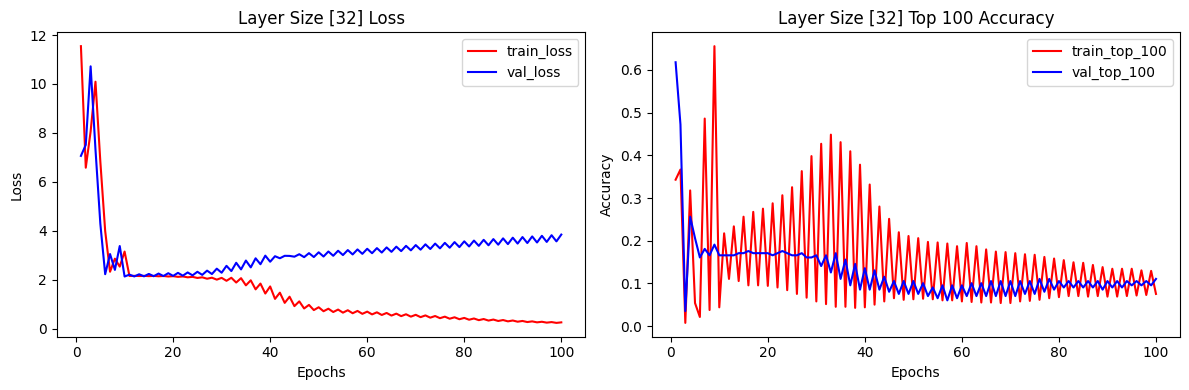

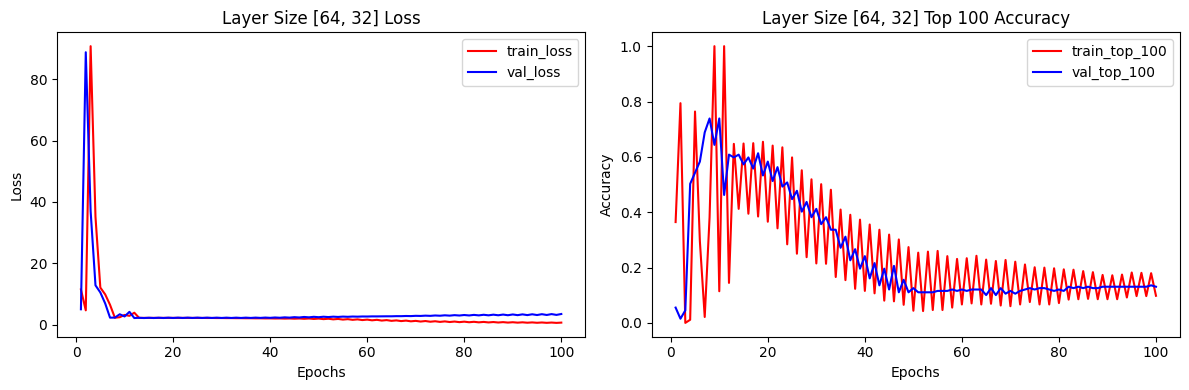

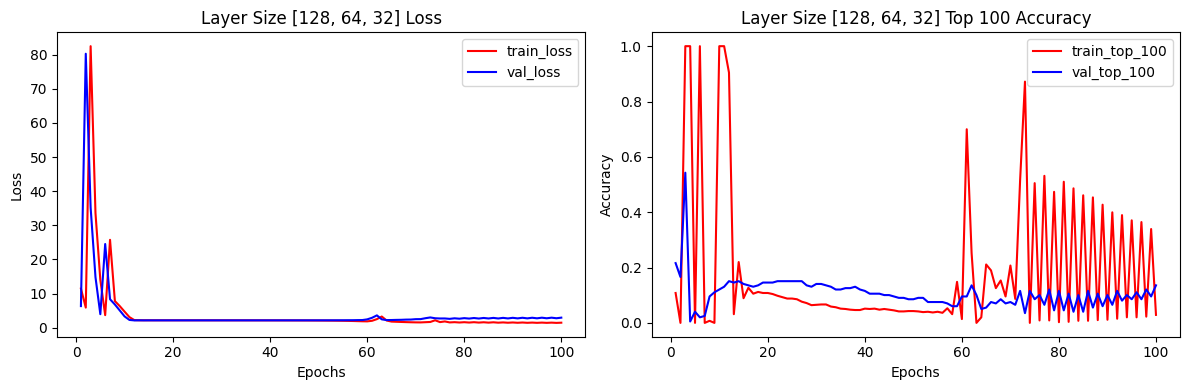

In [19]:
num_epochs = 100
layer_sizes = [[32],[64,32],[128,64,32]]
for layer_size in layer_sizes:
    model = MultitaskModel(layer_size, rating_weight=1, retrieval_weight=0)
    model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
    val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows))

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'Layer Size {layer_size} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_top_100, 'r', label='train_top_100')
    plt.plot(epochs, val_top_100, 'b', label='val_top_100')
    plt.title(f'Layer Size {layer_size} Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

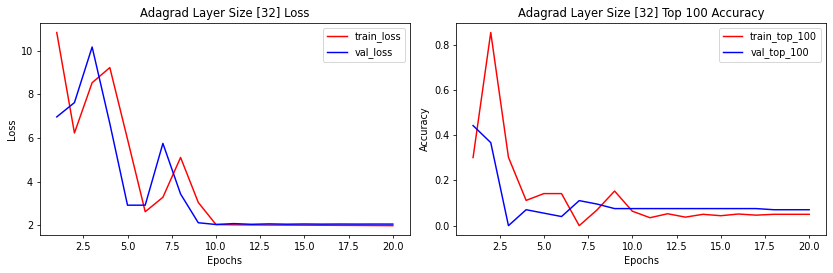

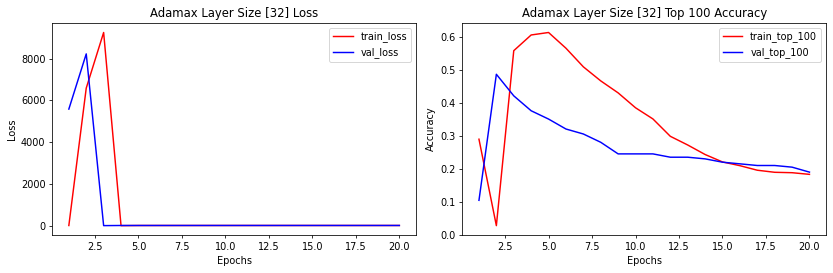

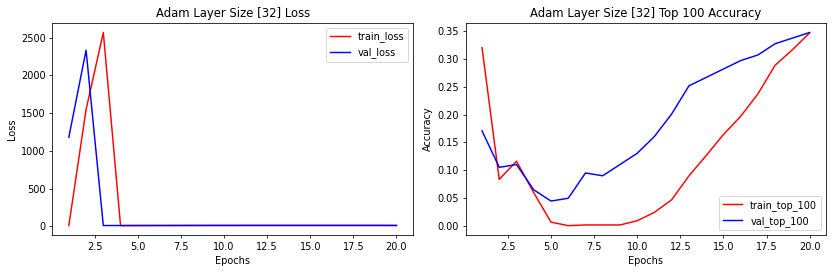

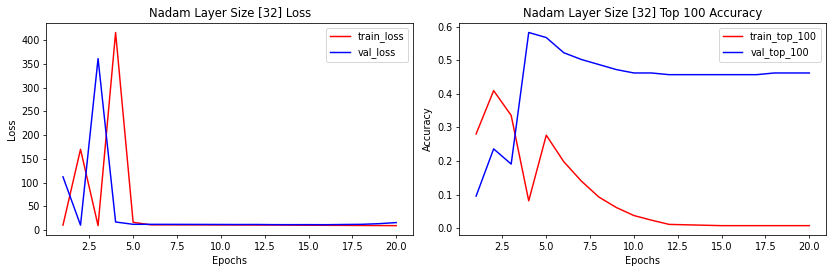

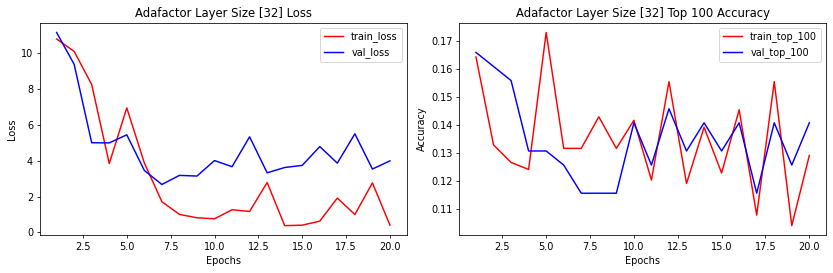

In [1097]:
optimizers = [
        tf.keras.optimizers.Adagrad,
        tf.keras.optimizers.Adamax,
        tf.keras.optimizers.Adam,
        tf.keras.optimizers.Nadam,
        tf.keras.optimizers.Adafactor,
    ]
colors = sns.color_palette('husl', len(optimizers))
for (optimizer, color) in zip(optimizers, colors):
    num_epochs = 20
    layer_size = [32]

    model = MultitaskModel(layer_size, rating_weight=1, retrieval_weight=0)
    model.compile(optimizer=optimizer(0.1))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
    val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows), dpi=70)

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'{optimizer().name} Layer Size {layer_size} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_top_100, 'r', label='train_top_100')
    plt.plot(epochs, val_top_100, 'b', label='val_top_100')
    plt.title(f'{optimizer().name} Layer Size {layer_size} Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### We pick Adagrad as one of the better achieving models.

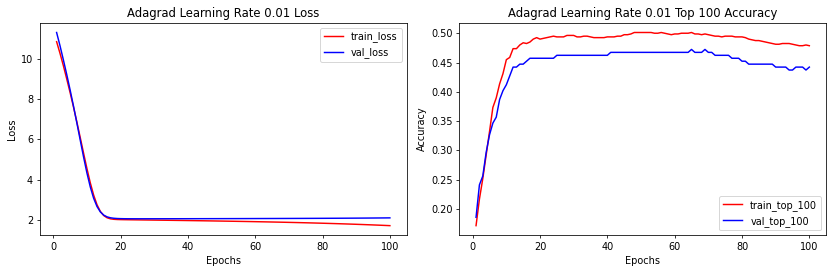

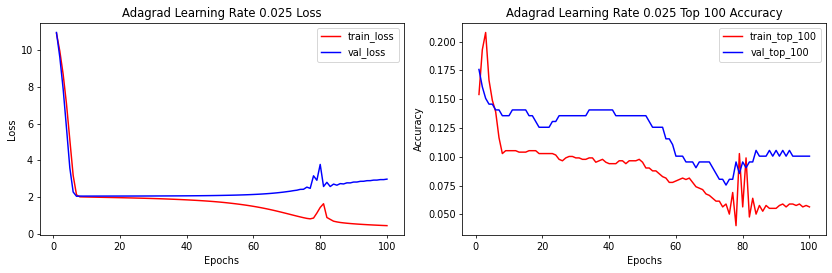

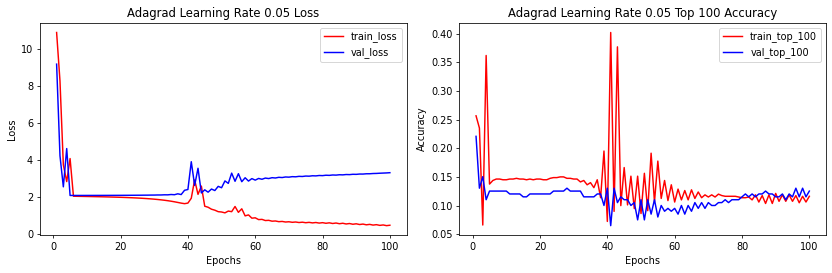

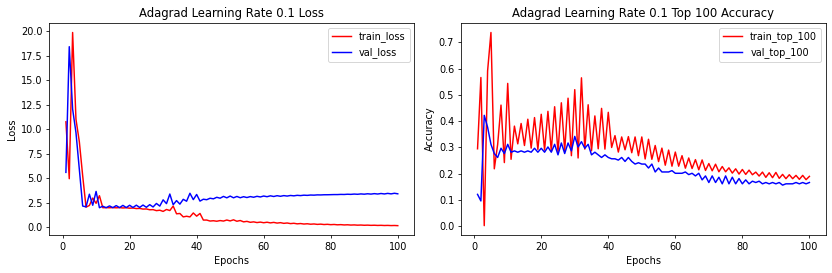

In [1098]:
optimizer=tf.keras.optimizers.Adagrad
learning_rates = [0.01,0.025,0.05,0.1]
for learning_rate in learning_rates:
    num_epochs = 100
    layer_size = [32]

    model = MultitaskModel(layer_size, rating_weight=1, retrieval_weight=0)
    model.compile(optimizer=optimizer(learning_rate=learning_rate))
    history = model.fit(cached_train, validation_data=cached_test, epochs=num_epochs, verbose=0)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_top_100 = history.history['factorized_top_k/top_100_categorical_accuracy']
    val_top_100 = history.history['val_factorized_top_k/top_100_categorical_accuracy']

    epochs = range(1, len(train_loss) + 1)

    rows,cols=(1,2)
    plt.figure(figsize=(6*cols,4*rows), dpi=70)

    plt.subplot(rows, cols, 1)
    plt.plot(epochs, train_loss, 'r', label='train_loss')
    plt.plot(epochs, val_loss, 'b', label='val_loss')
    plt.title(f'{optimizer().name} Learning Rate {learning_rate} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(rows, cols, 2)
    plt.plot(epochs, train_top_100, 'r', label='train_top_100')
    plt.plot(epochs, val_top_100, 'b', label='val_top_100')
    plt.title(f'{optimizer().name} Learning Rate {learning_rate} Top 100 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
model = MultitaskModel([32],rating_weight=1,retrieval_weight=0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
model.fit(cached_train, epochs=20, verbose=0)
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 460ms/step - root_mean_squared_error: 1.4641 - factorized_top_k/top_1_categorical_accuracy: 0.0402 - factorized_top_k/top_5_categorical_accuracy: 0.0553 - factorized_top_k/top_10_categorical_accuracy: 0.0804 - factorized_top_k/top_50_categorical_accuracy: 0.1910 - factorized_top_k/top_100_categorical_accuracy: 0.2814 - loss: 2.1436 - regularization_loss: 0.0000e+00 - total_loss: 2.1436


{'root_mean_squared_error': 1.464089035987854,
 'factorized_top_k/top_1_categorical_accuracy': 0.04020100459456444,
 'factorized_top_k/top_5_categorical_accuracy': 0.055276382714509964,
 'factorized_top_k/top_10_categorical_accuracy': 0.08040200918912888,
 'factorized_top_k/top_50_categorical_accuracy': 0.1909547746181488,
 'factorized_top_k/top_100_categorical_accuracy': 0.28140702843666077,
 'loss': 2.143556594848633,
 'regularization_loss': 0,
 'total_loss': 2.143556594848633}

### Note: make at least one inference before saving model.
This is done to make the model know which type of data it should be receiving.

# Model Serving

## Retrieval Model

In [21]:
user_id = random.choice(processed_df['user_id'])
processed_df.loc[processed_df['user_id']==user_id]

,user_id,user_rating,event_id,event_name,tags,interested
252,974,1,84,The Information Systems International Conferen...,"Conference, Education & Training, Instrumentat...",4
578,974,4,50,"International Conference on Mining, Material, ...","Conference, Industrial Engineering",16


In [22]:
# path = os.path.join(tmp, "model")
path = "./retrieval_model"

# Save the index.
tf.saved_model.save(index, path)

# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load(path)

# Pass a user id in, get top predicted event titles back.
key, titles = index(tf.constant([user_id]))
print(f"Recommendations for user {user_id}: {[str(i.numpy()) for i in titles[0, :]]}")

INFO:tensorflow:Assets written to: ./retrieval_model\assets


INFO:tensorflow:Assets written to: ./retrieval_model\assets


Recommendations for user 974: ["b'International Conference on Mining, Material, and Metallurgical Engineering (ICMMME)'", "b'International Conference on Mining, Material, and Metallurgical Engineering (ICMMME)'", "b'International Conference on Mining, Material, and Metallurgical Engineering (ICMMME)'", "b'International Conference on Mining, Material, and Metallurgical Engineering (ICMMME)'", "b'UN Network Conference'", "b'UN Network Conference'", "b'UN Network Conference'", "b'UN Network Conference'", "b'UN Network Conference'", "b'UN Network Conference'", "b'Lab Indonesia (LabIndo)'", "b'Lab Indonesia (LabIndo)'", "b'International Conference on Management and Information Technology (ICMIT)'", "b'International Conference on Management and Information Technology (ICMIT)'", "b'International Conference on Management and Information Technology (ICMIT)'", "b'International Conference on Management and Information Technology (ICMIT)'", "b'Electronics, Power, Communication, Control, and Instru

## Ranking Model

In [23]:
model = RankingModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))
model.fit(cached_train, epochs=20, verbose=0)
model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 0s 175ms/step - root_mean_squared_error: 1.7495 - loss: 3.0606 - regularization_loss: 0.0000e+00 - total_loss: 3.0606


{'root_mean_squared_error': 1.7494627237319946,
 'loss': 3.060619831085205,
 'regularization_loss': 0,
 'total_loss': 3.060619831085205}

In [24]:
set(zip(processed_df['event_name'].to_list(), processed_df['tags'].to_list()))

{('ACESR : ASEAN Conference on Engineering and Science Research',
  'Conference, Science & Research, Education & Training'),
 ('ALLPRINT INDONESIA', 'Tradeshow, Packing & Packaging, Print & Printing'),
 ('ANZI-Pacific Forum', 'Conference, Miscellaneous, Social Media'),
 ('APAC Family Office Investment Summit',
  'Conference, Banking & Finance, Investment'),
 ('APOS', 'Conference, Telecommunication, Entertainment & Media'),
 ('ASEAN Innovation Business Platform Conference & Exhibition Indonesia (AIBP Indonesia)',
  'Tradeshow, IT & Technology, Paid entry'),
 ('AVINER - International Conference on Aviation Industry, Education and Regulation of The Aerospace',
  'Conference, Education & Training, Logistics & Transportation, Aerospace'),
 ('Academic International Conference on Multi-Disciplinary Studies and Education',
  'Conference, Education & Training'),
 ('Access MBA One-to-One Event (Meet the best MBA schools)',
  'Conference, Education & Training, HR, Jobs & Career'),
 ('Advanced Fin

In [39]:
path = "./ranking_model"
tf.saved_model.save(model, path)
loaded = tf.saved_model.load(path)

model_rating_predictions = loaded(
        {"event_name": tf.constant(processed_df['event_name'].to_list(), dtype=tf.string),
        "tags": tf.constant(processed_df['tags'].to_list(), dtype=tf.string),
        "user_id": tf.constant([417]*len(processed_df.index), dtype=tf.int64)}
    )
rating_predictions = {id:rating[0].numpy() for id,rating in zip(processed_df['event_id'].to_list(),model_rating_predictions)}
sorted(rating_predictions.items(), key=lambda x: x[0])

INFO:tensorflow:Assets written to: ./ranking_model\assets


INFO:tensorflow:Assets written to: ./ranking_model\assets


[(1, 2.0836532),
 (2, 2.1900089),
 (3, 2.0645032),
 (4, 2.136893),
 (5, 2.1112874),
 (6, 2.2156777),
 (7, 2.1143558),
 (8, 2.1428785),
 (9, 2.2242029),
 (10, 2.1917188),
 (11, 2.1041596),
 (12, 2.1949756),
 (13, 2.2188365),
 (14, 2.2700512),
 (15, 2.177446),
 (16, 2.0900142),
 (18, 2.0942419),
 (19, 2.224558),
 (20, 2.148727),
 (21, 2.174939),
 (23, 2.1677535),
 (24, 2.0389216),
 (25, 2.1113672),
 (26, 2.2188365),
 (27, 2.1383915),
 (28, 2.1892657),
 (29, 2.2027364),
 (30, 2.1998944),
 (31, 2.1448631),
 (32, 2.0311334),
 (33, 2.1616452),
 (34, 2.2119448),
 (35, 2.256533),
 (36, 2.0676885),
 (37, 2.156956),
 (38, 2.1768801),
 (39, 2.1617348),
 (40, 2.1362007),
 (42, 2.0971768),
 (43, 2.225097),
 (44, 2.097689),
 (45, 2.2337978),
 (46, 2.2048242),
 (48, 2.199289),
 (49, 2.1598556),
 (50, 2.209853),
 (51, 2.2025778),
 (52, 2.2837188),
 (53, 2.1435173),
 (54, 2.1967146),
 (55, 2.166213),
 (56, 2.1620939),
 (57, 2.0870023),
 (58, 2.2077615),
 (59, 2.1981986),
 (60, 2.2342634),
 (61, 2.12607